In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import sys
sys.path.append("../../../../../src/")
import nanonets_utils
import nanonets
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright","grid"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

In [8]:
def mutal_capacitance_adjacent_spheres(eps_r: float, np_radius1: float, np_radius2: float, np_distance: float)->float:

    d       = (np_radius1 + np_radius2 + np_distance)
    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_r*(np_radius1*np_radius2)/d
    # Paper approx sum_val = 1
    sum_val = sum([1,(np_radius1*np_radius2)/(d**2-2*np_radius1*np_radius2),
                    ((np_radius1**2)*(np_radius2**2))/(d**4-4*(d**2)*np_radius1*np_radius2+3*(np_radius1**2)*(np_radius2**2))])
    cap     = factor*sum_val

    return np.round(cap,2)*1e-18

def self_capacitance_sphere(eps_s: float, np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_s
    cap     = factor*np_radius

    return np.round(cap,2)*1e-18

R   = 25*1e6
Cm  = mutal_capacitance_adjacent_spheres(2.6, 10, 10, 1)
Cs  = self_capacitance_sphere(3.9, 10)

## DC Input - Voltage Distribution - Closed Circuit

In [9]:
# folder  = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/"
folder      = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/"
N_voltages  = 40000
U_0         = 0.02
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq      = pd.DataFrame([pot[N_p].iloc[38000:,:].mean().values / U_0 for N_p in N_vals],index=N_vals).T.round(2)

### Steady State

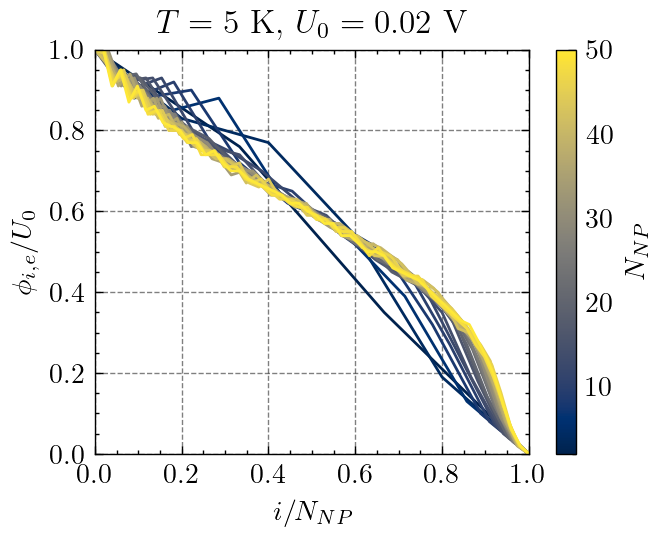

In [10]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    p   = np.insert(p, 0, 1.0)
    p   = np.append(p, 0.0)
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_potential.svg", transparent=True)

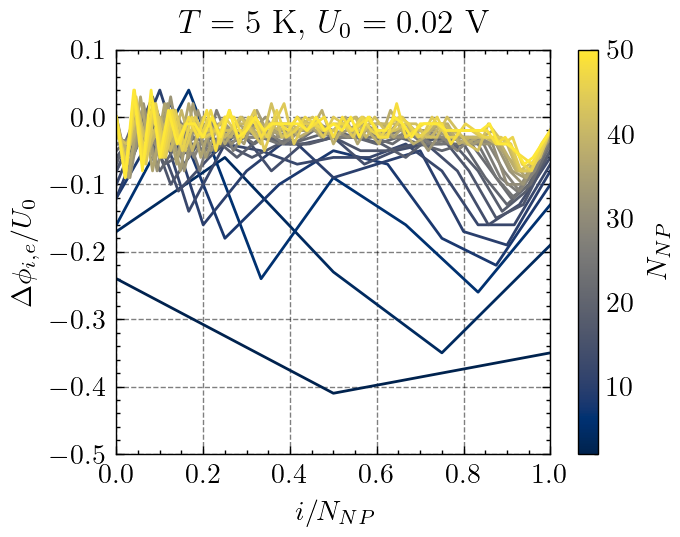

In [11]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    arr = pot_eq[N].dropna().values.copy()*U_0
    arr = np.insert(arr, 0, U_0)
    arr = np.append(arr, 0.0)
    arr = np.diff(arr)/U_0
    x   = np.linspace(0,1,len(arr))

    ax.plot(x, arr, color=cm(norm(N)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_xlim(0,1)
ax.set_ylim(-0.5, 0.1)
ax.set_ylabel("$\Delta \phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_potential_difference.svg", transparent=True)

There are three distinct regions:
- Alternating Pattern (First NPs)
  - Electrons tunneling into the string repel each other, creating **oscillatory potentials**
  - Example:
    - NP0 charges to $\phi_0 \approx U_0$
    - NP1 receives an electron, lowering $\phi_1$ slightly compared to $\phi_0$
    - NP2 then sees a reduced bias, leading to $\phi_2 > \phi_1$
  - **Standing charge wave**, where single-electron hops create local potential minima/maxima
- Quasi-Linear Decay (Middle NPs)
  - ***Averaging over many charge hops***
    - As charges propagate, the discreteness effects smear out, resembling a linear response but at **quanized steps**
    - The slope $d\phi / dk$ reflects the **effective resistance** per NP
- Rapid Drop (Last NPs)
  - The grounded electrode strongly attracts electrons, accelerating the drop in $\phi_k$
  - Charges near the end tunnel more frequently due to the larger $\Delta \phi$

### Characteristic Time Scale

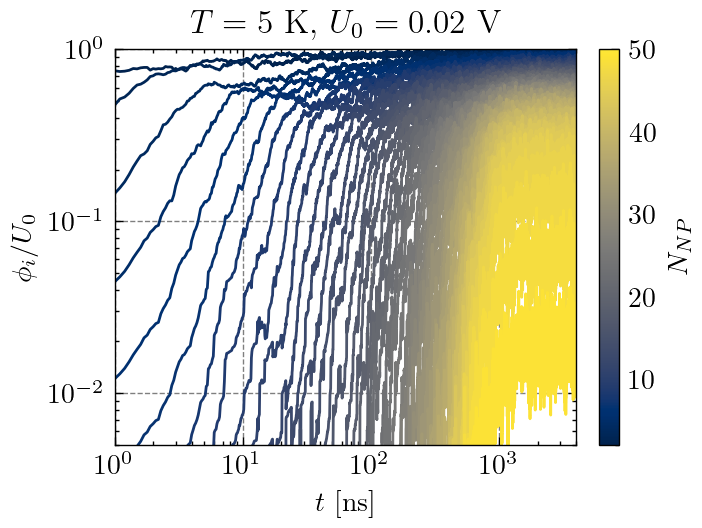

In [17]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))
Np      = 50

for i in range(Np):
    ax.plot(t_vals, pot[Np][f"{i}"].values/U_0, color=cm((i)/Np))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,4000)
ax.set_ylim(0.005,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_time_series.svg", transparent=True)

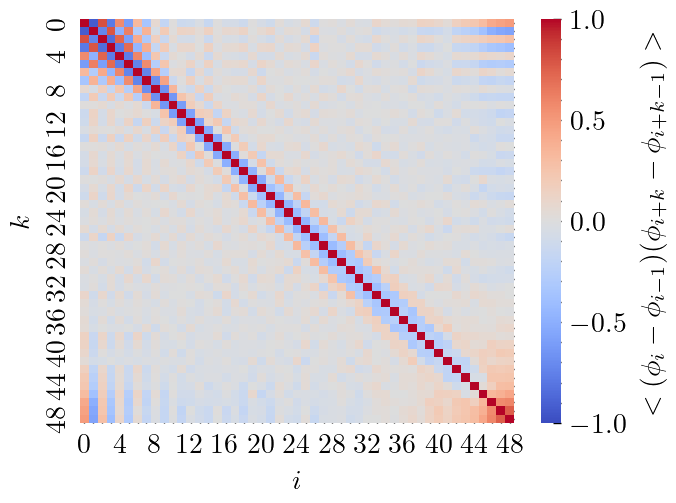

In [101]:
Np      = 50
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax, cbar_kws={"label":"$<(\phi_i-\phi_{i-1})(\phi_{i+k}-\phi_{i+k-1})>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_pot_diff_corr.svg", transparent=True)

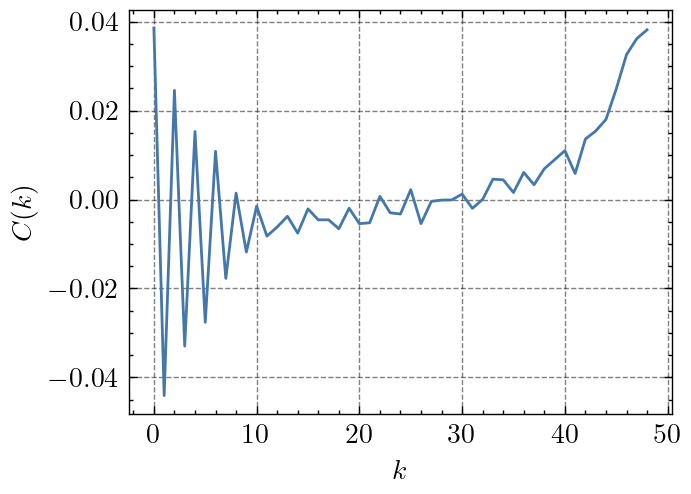

In [113]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(delta_p.corr().mean())
ax.set_xlabel("$k$")
ax.set_ylabel("$C(k)$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_pot_diff_corr_mean.svg", transparent=True)

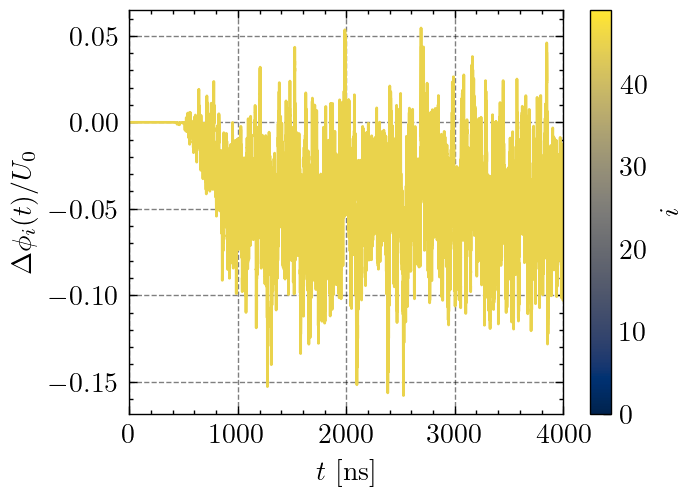

In [70]:
Np      = 50
norm    = Normalize(vmin=0, vmax=(Np-1))
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
i       = 45
ax.plot(t_f_d, p_diff[:,i]/U_0, color=cm(norm(i)), label=f'${i}$')
ax.set_xlim(-1,4000)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# ax.legend(fontsize='x-small', ncol=2)

In [71]:
def characteristic_time(t_vals, pot_df, Np, steady_start=20000, consecutive_points=50, p_th=0.63):

    end_vals    = pot_df[Np].iloc[steady_start:,:].mean().values
    taus        = []
    p_th        = 0.63

    for i in range(Np):
        vals        = pot_df[Np].loc[:,f'{i}'].values
        threshold   = p_th*end_vals[i]
        above_th    = vals > threshold
        for j in range(len(above_th) - consecutive_points):
            if all(above_th[j:j+consecutive_points]):
                tau = t_vals[j]
                taus.append(tau)
                break
    
    return taus

def characteristic_time_saturation(t_vals, pot_df, Np):

    def saturation_cuve(t, tau, a0, t0):
        return a0*(1 - np.exp(-(t-t0) / tau))

    tau = []
    std = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, cov  = curve_fit(saturation_cuve, x, y, bounds=((0,0,0),(np.inf,np.inf,np.inf)))
        tau.append(p[0])
        std.append(np.sqrt(cov[0,0]))

    return tau, std

def characteristic_time_stretched_saturation(t_vals, pot_df, Np, p0=None):

    def stretched_saturation_curve(t, tau, a0, beta):
        return a0*(1 - np.exp(-((t/tau)**beta)))

    tau     = []
    params  = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, cov  = curve_fit(stretched_saturation_curve, x, y, p0=p0, bounds=((0,0,0),(np.inf,np.inf,np.inf)), maxfev=5000)
        tau_val = gamma(1/p[2])*p[0]/p[2]
        tau.append(tau_val)
        params.append(p)

    return tau, params

In [77]:
Np                                  = 50
taus_hot, std_hot                   = characteristic_time_saturation(t_vals, pot, Np)
taus_hot_stretched, params_streched = characteristic_time_stretched_saturation(t_vals, pot, Np, p0=[50,1,1])

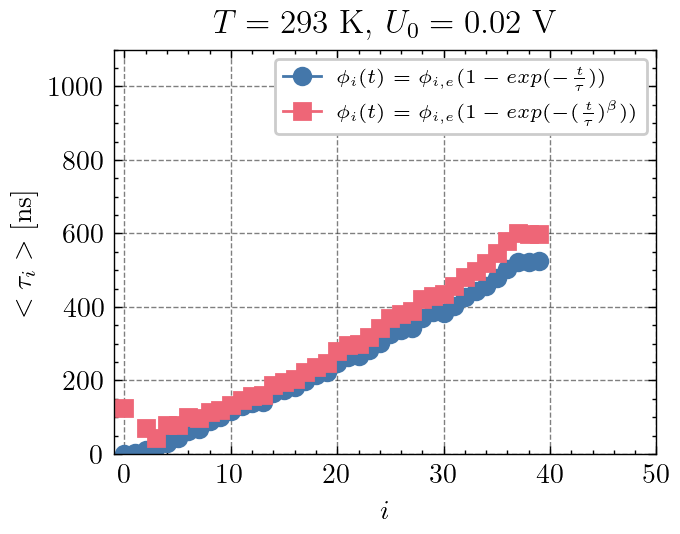

In [76]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, taus_hot, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(xp, taus_hot_stretched, '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
ax.set_ylim(0,1100)
ax.set_xlim(-1,50)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_time_scales.svg", transparent=True)

In [54]:
tau_s               = []
tau_s_stretched     = []

for Np in N_vals:
    taus, std   = characteristic_time_saturation(t_vals, pot, Np)
    tau_s.append(np.max(taus))
    taus, _     = characteristic_time_stretched_saturation(t_vals, pot, Np)
    tau_s_stretched.append(np.max(taus))

In [59]:
tau_s_stretched

[np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(2.0952234407243846e+223),
 np.float64(inf),
 np.float64(4.155472069591877e+230),
 np.float64(1.87660182727912e+287),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf)]

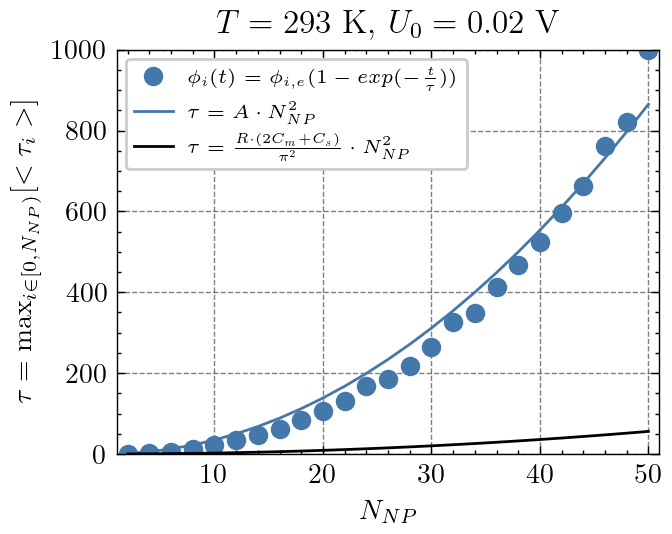

In [80]:
def quad_func(x, a):
    return a*x**2

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(quad_func, N_vals, tau_s)
pp  = ax.plot(N_vals, tau_s, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

# p,_ = curve_fit(quad_func, N_vals, tau_s_stretched)
# pp  = ax.plot(N_vals, tau_s_stretched, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
# ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

ax.plot(N_vals, quad_func(np.array(N_vals), R*(2*Cm+Cs)*1e9 / (np.pi**2)), color='black', label="$\\tau = \\frac{R \cdot (2C_m + C_s)}{\pi^2} \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
ax.set_ylim(0,1000)
ax.set_xlim(1,51)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_time_scales_vs_N.svg", transparent=True)

In [165]:
R*(2*Cm+Cs)*1e9 / (np.pi**2)

np.float64(0.02234132099313548)

Text(0.5, 0, '$t$ [ns]')

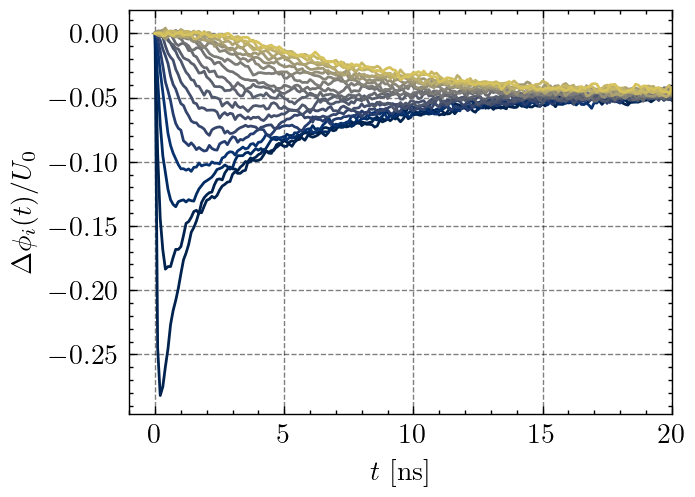

In [8]:
Np      = 20
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot_hot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0_hot, color=cm((i-1)/Np), label=f'${i}$')
ax.set_xlim(-1,20)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")
# ax.legend(fontsize='x-small', ncol=2)

Text(0.5, 0, '$t$ [ns]')

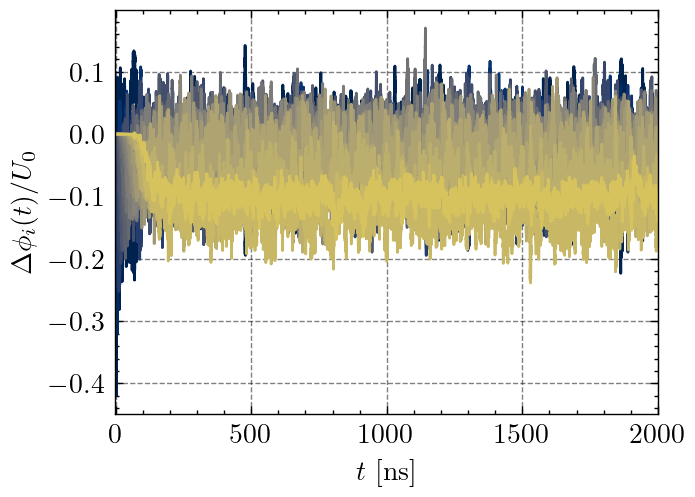

In [9]:
Np      = 20
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot_cold[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0_cold, color=cm((i-1)/Np))
ax.set_xlim(-1,2000)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")
# ax.legend(fontsize='x-small')

In [10]:
# from scipy.interpolate import griddata
# from scipy.signal import savgol_filter

# Np              = 20
# i               = 15
# stop            = 1000
# t               = t_vals.copy()[:stop]
# y               = pot_cold[Np][f"{i}"].copy().values[:stop]/U_0_cold
# # y               = pot_hot[Np][f"{i}"].copy().values[:stop]/U_0_hot
# window_size     = 41
# dy_dt_smooth    = savgol_filter(y, window_size, polyorder=2, deriv=1, delta=t[1]-t[0])
# dy_dt           = dy_dt_smooth
# y_grid          = np.linspace(min(y), max(y), 100)
# dy_grid         = np.linspace(min(dy_dt), max(dy_dt), 100)
# Y, DY           = np.meshgrid(y_grid, dy_grid)
# dY_grid         = griddata((y, dy_dt), dy_dt, (Y, DY), method='linear')  # dy/dt
# dDY_grid        = griddata((y, dy_dt), np.gradient(dy_dt, t), (Y, DY), method='linear')  # d²y/dt²

# # Plot phase space with streamplot
# fig     = plt.figure(dpi=200)
# ax      = fig.add_subplot()
# strm    = ax.streamplot(
#         Y, DY, dY_grid, dDY_grid,
#         arrowsize=1,              # Larger arrows
#         arrowstyle='->',            # Arrow style
#         density=1.0,                # Higher density of lines
#         maxlength=2000,             # Longer trajectories
#         integration_direction='both'  # Integrate forward/backward
# )
# ax.set_xlabel("$\phi(t)$")
# ax.set_ylabel("$\dot{\phi}(t)$")

# Np      = 20
# i       = 10
# start   = 10000
# t       = t_vals.copy()[start:]
# # y       = pot_hot[Np][f"{i}"].copy().values[start:]/U_0_hot
# dy_dt   = np.gradient(y, t)
# y       = pot_cold[Np][f"{i}"].copy().values[start:]/U_0_cold
# fig     = plt.figure(dpi=200)
# ax      = fig.add_subplot()
# im      = ax.hist2d(y, dy_dt, bins=[100,100], cmap='cividis', range=[[0,1],[-1,1]])
# # im      = ax.hexbin(y, dy_dt_smooth, gridsize=100, cmap='cividis', mincnt=1)
# cb      = fig.colorbar(im[3], label='Density', ax=ax)
# ax.set_xlabel("$\phi(t)$")
# ax.set_ylabel("$\dot{\phi}(t)$")
# # fixed_points_mask = np.abs(dy_dt_smooth) < 0.01 * np.max(dy_dt_smooth)  # Threshold
# # ax.scatter(
# #     y[fixed_points_mask], 
# #     dy_dt_smooth[fixed_points_mask], 
# #     color='red', 
# #     s=5, 
# #     alpha=0.5,
# #     label='Fixed points'
# # )
# # plt.xlabel('y(t)')
# # plt.ylabel('dy/dt')

# # plt.hexbin(y, dy_dt_smooth, gridsize=100, cmap='cividis', mincnt=1)

In [11]:
# fig = plt.figure(dpi=200, layout='constrained')
# fig.set_figwidth(fig.get_figwidth()*2)
# ax      = fig.add_subplot(1,2,1)
# cm      = plt.get_cmap('cividis')
# taus    = []
# taus1   = []
# taus2   = []
# betas   = []
# starts  = [10,10,10,10,20,20,20,20,30,30,30,30,40,40,40,40,50,50,50,50]
# starts  = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]

# for i in range(Np):
#     x, y    = t_vals[starts[i]:500], pot_hot[Np][f"{i}"].values[starts[i]:500]/U_0_hot
#     p,c     = curve_fit(stretched_saturation_curve, x, y, maxfev=10000, p0=[1,1,1], bounds=[(0,0,0),(10,1,2)])#, p0=[1,5,1.0,0.0,0.0], bounds=[(0,0,0,0,0),(10,10,1,2,2)])
#     taus.append(p[0])
#     taus1.append(p[0])
#     taus2.append(p[1])
#     betas.append(p[2])
#     print(p)

#     ax.plot(x, y, color=cm((i+1)/Np), ms=4)#, marker='.')
#     ax.plot(x, stretched_saturation_curve(x, *p), color=cm((i+1)/Np), ls='--')

# tau = gamma(1/np.array(betas))*np.array(taus)/np.array(betas)
# ax.set_xlim(1,50)
# # ax.set_ylim(0.001,1)
# ax.set_ylim(0.01,1)
# ax.set_ylabel("$\phi_i / U_0$")
# ax.set_xlabel("$t$ [ns]")
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")

# ax  = fig.add_subplot(1,2,2)
# ax.plot(range(Np), tau, 'o-', label='$<\\tau> = \\frac{\\tau}{\\beta} \cdot \Gamma(\\frac{1}{\\beta})$')
# # ax.plot(range(Np), taus1, 'o-', label='$\\tau_1$')
# # ax.plot(range(Np), taus2, 'o-', label='$\\tau_2$')
# ax.set_ylabel('$<\\tau_i>$ [ns]')
# ax.set_xlabel("$i$")
# ax.set_ylim(0,10)
# ax.set_xlim(-1,20)
# ax.set_title("$\phi \propto U_0 \cdot (1 - e^{-(t/\\tau)^{\\beta}})$")
# ax.legend(fontsize='small')

# fig.savefig("../plots/dc_input/closed_circuit_room_temp_fit.svg", transparent=True)

In [12]:
# current_cold    = {N_p : pd.read_csv(f"{folder_cold}Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
# current_hot     = {N_p : pd.read_csv(f"{folder_hot}Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}

In [13]:
# fig = plt.figure(dpi=200, layout='constrained')
# fig.set_figwidth(fig.get_figwidth()*2)
# ax1 = fig.add_subplot(1,2,1)
# ax2 = fig.add_subplot(1,2,2)
# cm  = plt.get_cmap('cividis')
# Np  = 20

# for i in N_vals:
#     ax1.plot(t_vals, current_cold[i]['Current'].values, color=cm((i+1)/Np), marker='.', ms=2)
#     ax1.fill_between(t_vals, current_cold[i]['Current'].values-current_cold[i]['Error'].values,
#                      current_cold[i]['Current'].values+current_cold[i]['Error'].values, color='black', alpha=0.2)
#     ax2.plot(t_vals, current_hot[i]['Current'].values, color=cm((i+1)/Np), marker='.', ms=2)
#     ax2.fill_between(t_vals, current_hot[i]['Current'].values-current_hot[i]['Error'].values,
#                      current_hot[i]['Current'].values+current_hot[i]['Error'].values, color='black', alpha=0.2)

# ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
# ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
# ax1.set_xlabel("$t$ [ns]")
# ax1.set_xlim(1,4000)
# ax2.set_xlim(1,4000)
# # ax1.set_ylim(0.0001,10000)
# # ax2.set_ylim(10,100000)
# # ax1.set_yscale('log')
# # ax2.set_yscale('log')
# ax1.set_xscale('log')
# ax2.set_xscale('log')
# ax1.set_ylabel("$I$ [pA]")
# ax1.set_xlabel("$t$ [ns]")
# ax2.set_ylabel("$I$ [pA]")
# ax2.set_xlabel("$t$ [ns]")

## DC Input - Voltage Distribution - Open Circuit

In [14]:
folder_cold = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/"
folder_hot  = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
# folder_cold = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/"
# folder_hot  = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
N_voltages  = 40000
U_0_cold    = 0.02
U_0_hot     = 1.0
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20]
pot_cold    = {N_p : pd.read_csv(f"{folder_cold}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_hot     = {N_p : pd.read_csv(f"{folder_hot}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq_cold = pd.DataFrame([pot_cold[N_p].iloc[38000:,:].mean().values / U_0_cold for N_p in N_vals],index=N_vals).T.round(2)
pot_eq_hot  = pd.DataFrame([pot_hot[N_p].iloc[38000:,:].mean().values / U_0_hot for N_p in N_vals],index=N_vals).T.round(2)

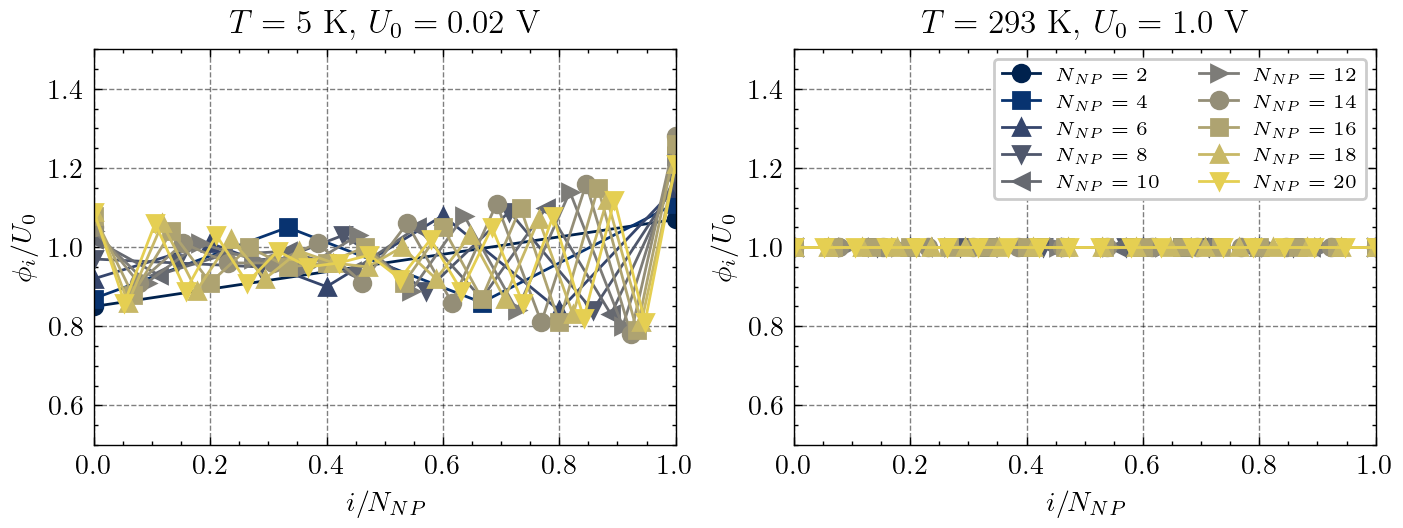

In [15]:
ma  = ["o","s","^","v","<",">"]
cm  = plt.get_cmap('cividis')
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for i, N in enumerate(N_vals):

    p_cold  = pot_eq_cold[N].dropna().values.copy()
    p_hot   = pot_eq_hot[N].dropna().values.copy()
    x       = np.linspace(0,1,len(p_cold))
    ax1.plot(x, p_cold, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$", color=cm((i)/len(N_vals)))
    ax2.plot(x, p_hot, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$", color=cm((i)/len(N_vals)))

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_ylim(0.5,1.5)
ax2.set_ylim(0.5,1.5)
# ax2.set_ylim(-1,1)
ax1.set_xlim(0,1)
ax2.set_xlim(0,1)
ax1.set_ylabel("$\phi_i / U_0$")
ax2.set_ylabel("$\phi_i / U_0$")
ax1.set_xlabel("$i / N_{NP}$")
ax2.set_xlabel("$i / N_{NP}$")
ax2.legend(ncol=2, fontsize='x-small')

fig.savefig("../plots/dc_input/open_circuit_node_potential_vs_T.svg", transparent=True)

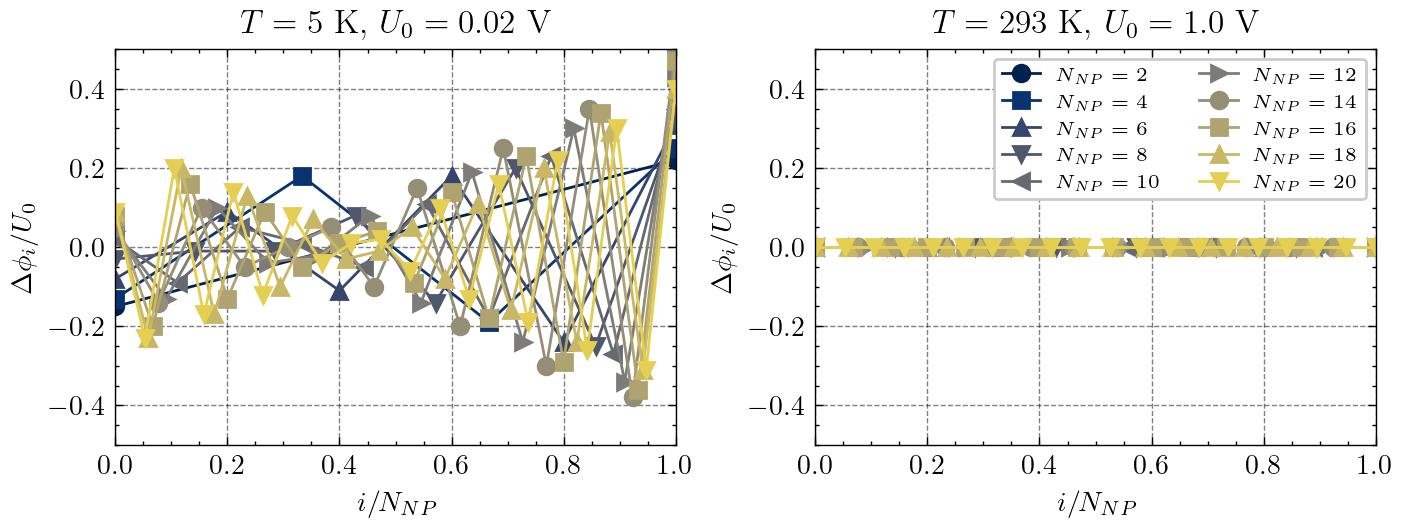

In [16]:
ma  = ["o","s","^","v","<",">"]
cm  = plt.get_cmap('cividis')
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for i, N in enumerate(N_vals):

    arr_cold    = np.insert(pot_eq_cold[N].dropna().values*U_0_cold, 0, U_0_cold)
    arr_cold    = np.diff(arr_cold)

    arr_hot = np.insert(pot_eq_hot[N].dropna().values*U_0_hot, 0, U_0_hot)
    arr_hot = np.diff(arr_hot)

    x       = np.linspace(0,1,len(arr_cold))


    ax1.plot(x, arr_cold/U_0_cold, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$", color=cm((i)/len(N_vals)))
    ax2.plot(x, arr_hot/U_0_hot, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$", color=cm((i)/len(N_vals)))

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_xlim(0,1)
ax2.set_xlim(0,1)
ax1.set_ylim(-0.5, 0.5)
ax2.set_ylim(-0.5, 0.5)
ax1.set_ylabel("$\Delta \phi_i / U_0$")
ax2.set_ylabel("$\Delta \phi_i / U_0$")
ax1.set_xlabel("$i / N_{NP}$")
ax2.set_xlabel("$i / N_{NP}$")
ax2.legend(ncol=2, fontsize='x-small')

fig.savefig("../plots/dc_input/open_circuit_node_potential_difference_vs_T.svg", transparent=True)

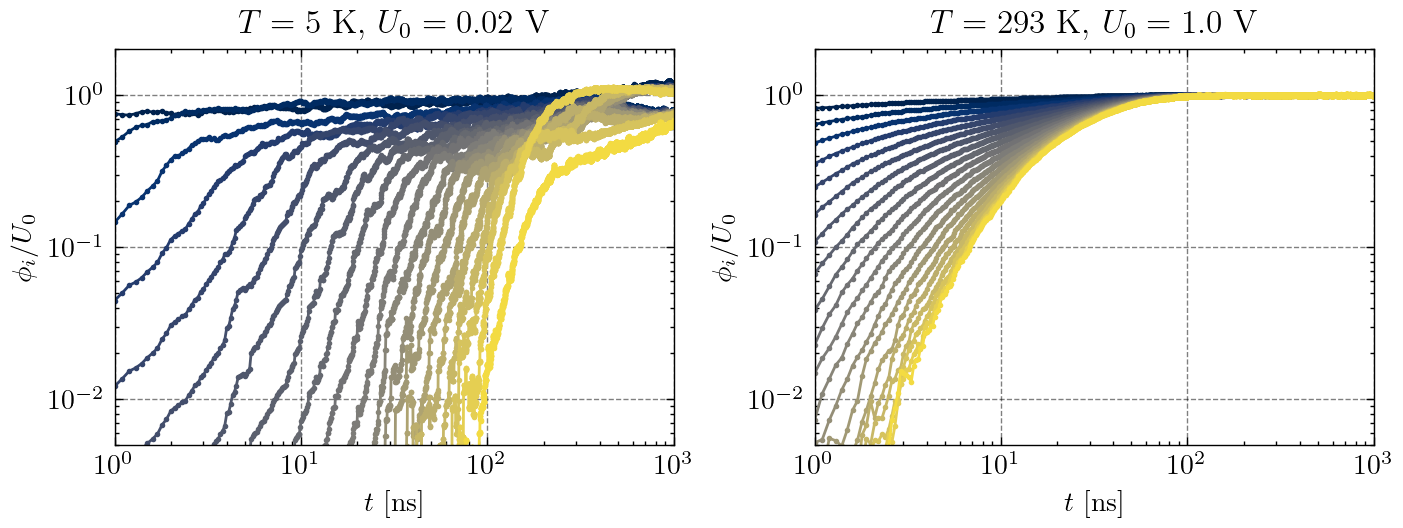

In [17]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
cm  = plt.get_cmap('cividis')
Np  = 20

for i in range(Np):
    ax1.plot(t_vals, pot_cold[Np][f"{i}"].values/U_0_cold, color=cm((i)/Np), marker='.', ms=2)
    p = ax2.plot(t_vals, pot_hot[Np][f"{i}"].values/U_0_hot, color=cm((i)/Np), marker='.', ms=2)

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_xlabel("$t$ [ns]")
ax1.set_xlim(1,1000)
ax2.set_xlim(1,1000)
ax1.set_ylim(0.005,2)
ax2.set_ylim(0.005,2)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylabel("$\phi_i / U_0$")
ax1.set_xlabel("$t$ [ns]")
ax2.set_ylabel("$\phi_i / U_0$")
ax2.set_xlabel("$t$ [ns]")

fig.savefig("../plots/dc_input/open_circuit_node_time_series_vs_T.svg", transparent=True)

In [18]:
Np                  = 20
end_vals_cold       = pot_cold[Np].iloc[10000:,:].mean().values
end_vals_hot        = pot_hot[Np].iloc[10000:,:].mean().values
taus_cold           = []
taus_hot            = []
p_th                = 0.63
con_points_cold     = 50
con_points_hot      = 10

for i in range(Np):
    # For hot
    hot_vals        = pot_hot[Np].loc[:,f'{i}'].values
    hot_threshold   = p_th*end_vals_hot[i]
    above_th        = hot_vals > hot_threshold
    # Find where we have N consecutive points above threshold
    for j in range(len(above_th) - con_points_hot):
        if all(above_th[j:j+con_points_hot]):
            tau = t_vals[j]
            taus_hot.append(tau)
            break
    
    # For cold
    cold_vals       = pot_cold[Np].loc[:,f'{i}'].values
    cold_threshold  = p_th*end_vals_cold[i]
    above_th        = cold_vals > cold_threshold
    # Find where we have N consecutive points above threshold
    for j in range(len(above_th) - con_points_cold):
        if all(above_th[j:j+con_points_cold]):
            tau = t_vals[j]
            taus_cold.append(tau)
            break

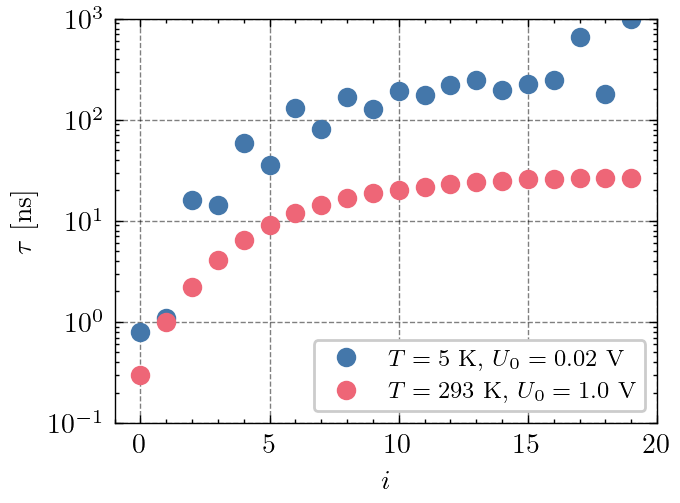

In [19]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(range(Np), taus_cold, 'o', label=f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax.plot(range(Np), taus_hot, 'o', label=f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax.set_xlabel("$i$")
ax.set_ylabel("$\\tau$ [ns]")
ax.set_ylim(0.1,1000)
ax.set_xlim(-1,20)
ax.legend(fontsize='small')
ax.set_yscale('log')

fig.savefig("../plots/dc_input/open_circuit_node_time_scales_vs_T.svg", transparent=True)

Text(0.5, 0, '$t$ [ns]')

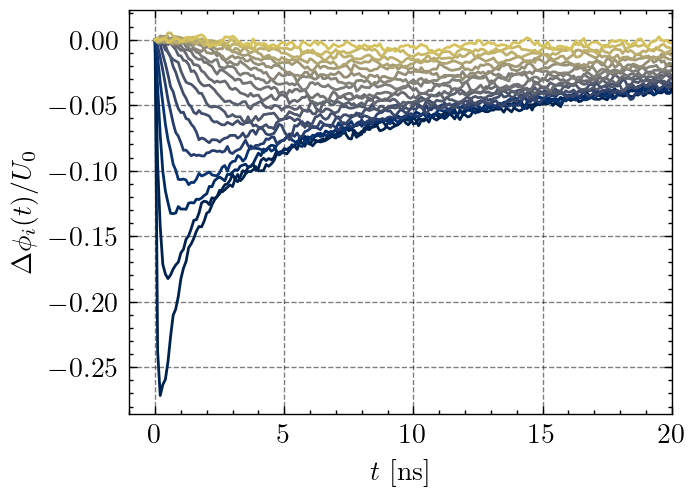

In [24]:
Np      = 20
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot_hot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0_hot, color=cm((i-1)/Np), label=f'${i}$')
ax.set_xlim(-1,20)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")
# ax.legend(fontsize='x-small', ncol=2)

Text(0.5, 0, '$t$ [ns]')

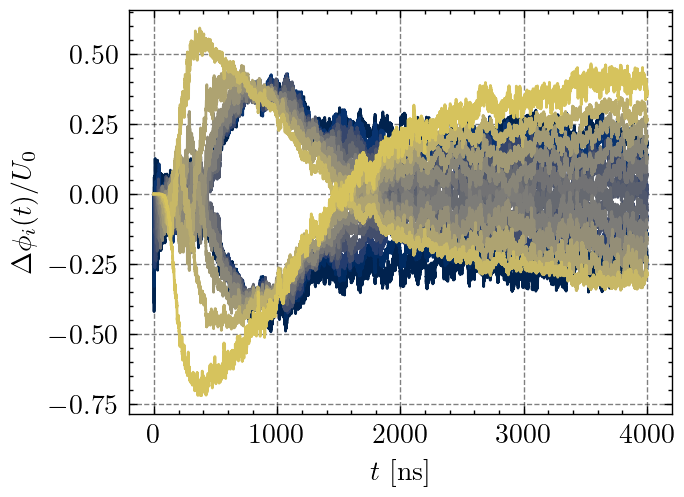

In [22]:
Np      = 20
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot_cold[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0_cold, color=cm((i-1)/Np))
# ax.set_xlim(-1,2000)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")
# ax.legend(fontsize='x-small')

[0.05412568 1.02740282 0.17482988]
[0.8486502  1.04359241 0.25053736]
[2.69056036 1.04072091 0.33283724]
[5.19698842 1.03973923 0.40877529]
[7.78693352 1.03138726 0.48963021]
[10.28801846  1.02328281  0.56796684]
[12.64805104  1.01494102  0.64823196]
[14.66157486  1.00374548  0.73017314]
[16.35807105  0.99091822  0.81479374]
[17.78210483  0.97752363  0.89906419]
[19.01250911  0.96401038  0.98521287]
[19.92464102  0.94809561  1.07581753]
[20.63110785  0.93183371  1.16613032]
[21.29486356  0.91980571  1.24819168]
[21.87502366  0.90947369  1.32216256]
[22.27171741  0.89910812  1.39284325]
[22.57202332  0.89050252  1.44951407]
[22.77331632  0.88308683  1.49879014]
[23.00097565  0.88063531  1.52566227]
[23.10746999  0.87884743  1.54020962]


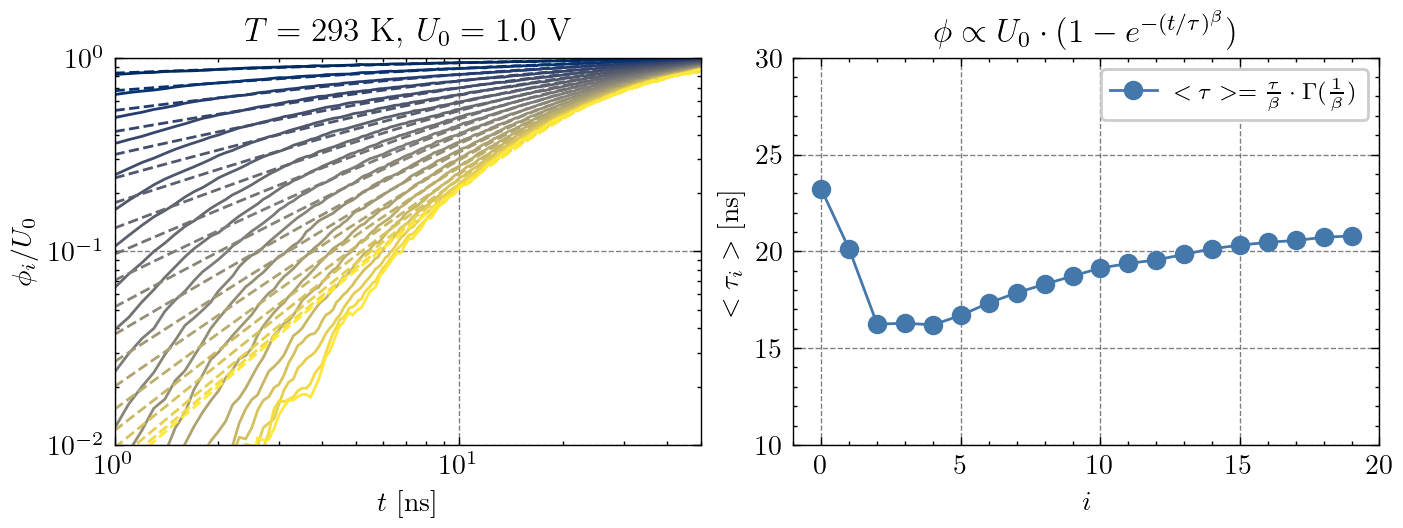

In [148]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax      = fig.add_subplot(1,2,1)
cm      = plt.get_cmap('cividis')
taus    = []
taus1   = []
taus2   = []
betas   = []
starts  = [10,10,10,10,20,20,20,20,30,30,30,30,40,40,40,40,50,50,50,50]
starts  = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]

for i in range(Np):
    x, y    = t_vals[starts[i]:500], pot_hot[Np][f"{i}"].values[starts[i]:500]/U_0_hot
    p,c     = curve_fit(stretched_saturation_curve, x, y, maxfev=10000, p0=[1,1,1], bounds=[(0,0,0),(50,2,2)])#, p0=[1,5,1.0,0.0,0.0], bounds=[(0,0,0,0,0),(10,10,1,2,2)])
    taus.append(p[0])
    taus1.append(p[0])
    taus2.append(p[1])
    betas.append(p[2])
    print(p)

    ax.plot(x, y, color=cm((i+1)/Np), ms=4)#, marker='.')
    ax.plot(x, stretched_saturation_curve(x, *p), color=cm((i+1)/Np), ls='--')

tau = gamma(1/np.array(betas))*np.array(taus)/np.array(betas)
ax.set_xlim(1,50)
# ax.set_ylim(0.001,1)
ax.set_ylim(0.01,1)
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")

ax  = fig.add_subplot(1,2,2)
ax.plot(range(Np), tau, 'o-', label='$<\\tau> = \\frac{\\tau}{\\beta} \cdot \Gamma(\\frac{1}{\\beta})$')
# ax.plot(range(Np), taus1, 'o-', label='$\\tau_1$')
# ax.plot(range(Np), taus2, 'o-', label='$\\tau_2$')
ax.set_ylabel('$<\\tau_i>$ [ns]')
ax.set_xlabel("$i$")
ax.set_ylim(10,30)
ax.set_xlim(-1,20)
ax.set_title("$\phi \propto U_0 \cdot (1 - e^{-(t/\\tau)^{\\beta}})$")
ax.legend(fontsize='small')

fig.savefig("../plots/dc_input/open_circuit_room_temp_fit.svg", transparent=True)

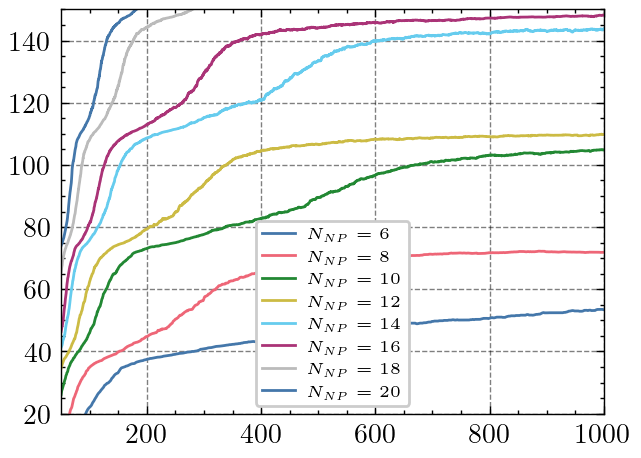

In [4]:
taus    = [21,10.4,5.6,3.5,2.4,1.8,1.3,1]
p, c    = curve_fit(pot_law, np.array(N_vals[2:]), taus)

plt.figure(dpi=200)
for i, N in enumerate(N_vals[2:]):
    plt.plot(t_vals*taus[i], data_string[N]['Current'].values*1000, label='$N_{NP} = '+f'{N}$')

plt.xlim(50,1000)
plt.ylim(20,150)
plt.legend(fontsize='xx-small')

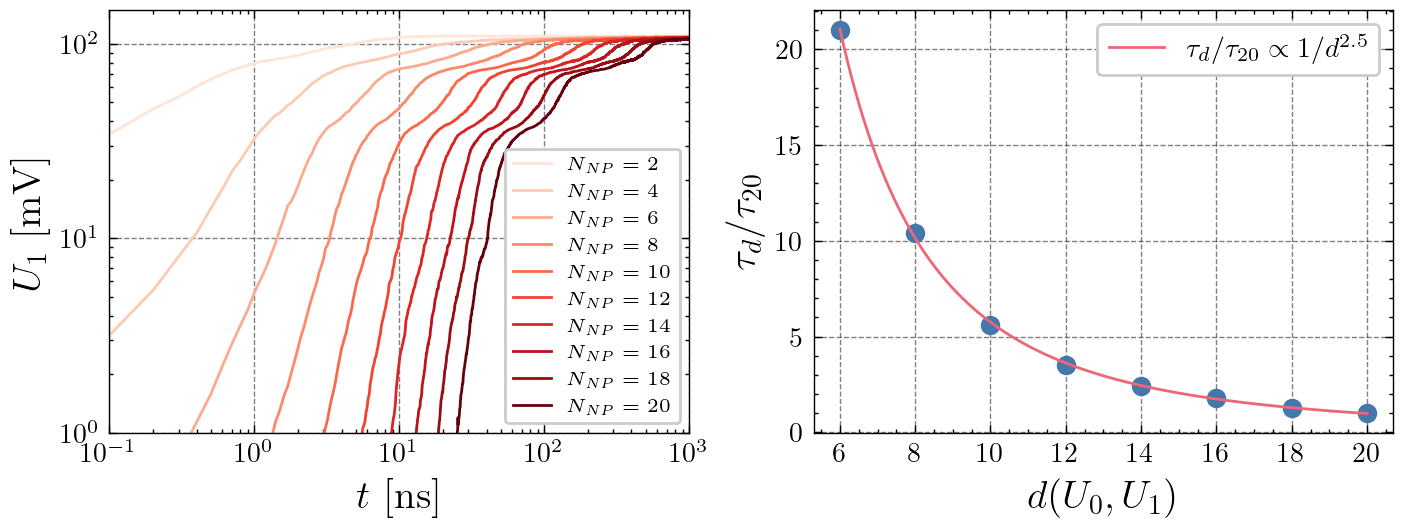

In [18]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ms  = ['o','s','^','v','<','>']
cm  = plt.get_cmap('Reds')

for i, N in enumerate(N_vals):

    y_val   = data_string[N]['Current'].values*1000
    y_val_e = data_string[N]['Error'].values*1000
    pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', c=cm((i+1)/len(N_vals)))

ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')
ax.set_xlabel("$t$ [ns]", fontsize='x-large')
ax.legend(frameon=True, loc='lower right', fontsize='x-small', ncol=1)
ax.set_ylim(1,150)
ax.set_xlim(0.1,1000)
ax.set_xscale('log')
ax.set_yscale('log')

ax  = fig.add_subplot(1,2,2)
ax.plot(np.array(N_vals[2:]), taus, 'o')
ax.plot(np.linspace(N_vals[2],N_vals[-1],1000), func(np.linspace(N_vals[2],N_vals[-1],1000),*p), label="$\\tau_d / \\tau_{20} \propto 1/d^{"+f"{-np.round(p[1],1)}"+"}$")
ax.set_ylabel("$\\tau_{d} / \\tau_{20}$", fontsize='x-large')
ax.set_xlabel("$d(U_0,U_1)$", fontsize='x-large')
ax.set_xticks(N_vals[2:])
ax.legend()

fig.savefig("../plots/string_time_scale_vs_system_size.svg", transparent=True)
fig.savefig("../plots/string_time_scale_vs_system_size.pdf", transparent=False)

In [6]:
taus    = []
tau_m   = []
params  = []
covs    = []

for i, N in enumerate(N_vals):
    x_fit   = t_vals.copy()
    y_fit   = data_string[N]['Current'].values*1000
    # p, cov  = curve_fit(stretched_saturation_curve, x_fit, y_fit, p0=[10,100,1.0], bounds=[(0,0,0),(500,120,2)])
    p, cov  = curve_fit(saturation_cuve, x_fit, y_fit, p0=[10,100,1.0], bounds=[(0,80,0),(500,120,20)])
    taus.append(p[0])
    params.append(p)
    covs.append(np.sqrt(cov[0,0]))
    tau_m.append(p[0]/p[2] * gamma(1 / p[2]))
    
params

[array([1.60015509e+00, 1.03222185e+02, 3.38248978e-18]),
 array([6.87494356e+00, 1.06505458e+02, 1.86541772e-15]),
 array([1.61888535e+01, 1.03320463e+02, 5.62083227e-19]),
 array([3.42083950e+01, 1.03001236e+02, 1.36004593e-23]),
 array([6.47660070e+01, 1.03127269e+02, 3.62676747e-25]),
 array([1.01835044e+02, 1.02259691e+02, 1.91749288e-26]),
 array([1.48732338e+02, 1.01774407e+02, 3.12229083e-25]),
 array([2.06097830e+02, 1.01184761e+02, 5.32583098e-26]),
 array([2.74897536e+02, 1.00287984e+02, 3.72935542e-24]),
 array([3.43525165e+02, 9.91502037e+01, 2.69950599e-23])]

ValueError: x and y must have same first dimension, but have shapes (10,) and (8,)

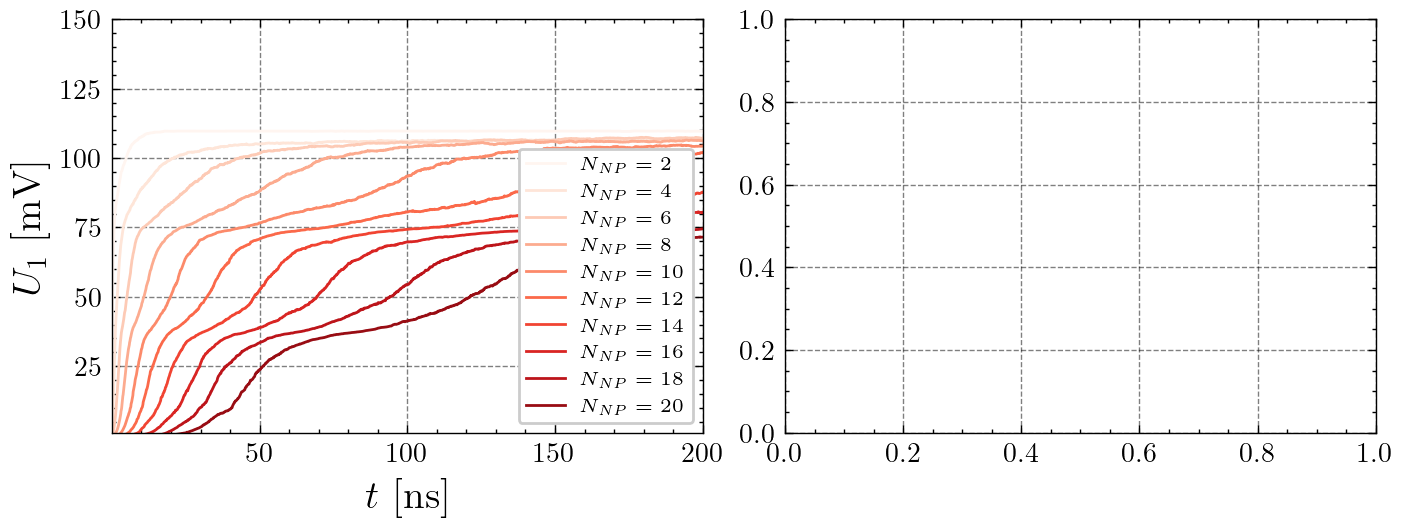

In [124]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ms  = ['o','s','^','v','<','>']
cm  = plt.get_cmap('Reds')

for i, N in enumerate(N_vals):

    y_val   = data_string[N]['Current'].values*1000
    y_val_e = data_string[N]['Error'].values*1000
    pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', c=cm((i)/len(N_vals)))
    # pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', marker=ms[i%len(ms)], markevery=(20,100), ls='')
    # ax.plot(t_vals, stretched_saturation_curve(t_vals,*params[i]), c=pp[0].get_color())
    # ax.plot(t_vals, saturation_cuve(t_vals,*params[i]), c=pp[0].get_color())
    # ax.fill_between(t_vals, y_val-y_val_e, y_val+y_val_e, color='black', alpha=0.2)

ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')
ax.set_xlabel("$t$ [ns]", fontsize='x-large')
ax.legend(frameon=True, loc='lower right', fontsize='x-small', ncol=1)
ax.set_ylim(1,150)
ax.set_xlim(0.1,200)
# ax.set_xscale('log')
# ax.set_yscale('log')

ax  = fig.add_subplot(1,2,2)
ax.plot(np.array(N_vals), taus, 'o')
ax.plot(np.array(N_vals), 0.26*np.array(N_vals)**2.4)
ax.set_ylabel("$\\tau$ [ns]", fontsize='x-large')
ax.set_xlabel("$d(U_0,U_1)$", fontsize='x-large')
ax.set_xticks(N_vals)
# ax.set_ylim(0,40)
ax.set_xscale('log')
ax.set_yscale('log')

# fig.savefig("../plots/string_time_scale_vs_system_size.svg", transparent=True)
# fig.savefig("../plots/string_time_scale_vs_system_size.pdf", transparent=False)

## @ 293K

In [32]:
taus    = []
tau_m   = []
params  = []
covs    = []

for i, N in enumerate(N_vals):
    x_fit   = t_vals.copy()
    y_fit   = data_string[N]['Current'].values*1000
    # p, cov  = curve_fit(stretched_saturation_curve, x_fit, y_fit, p0=[10,100,1.0], bounds=[(0,0,0),(500,120,2)])
    p, cov  = curve_fit(saturation_cuve, x_fit, y_fit, p0=[10,100,1.0], bounds=[(0,80,0),(500,120,20)])
    taus.append(p[0])
    params.append(p)
    covs.append(np.sqrt(cov[0,0]))
    tau_m.append(p[0]/p[2] * gamma(1 / p[2]))
    
params

[array([3.60208636e-01, 9.99983951e+01, 2.70140781e-14]),
 array([1.30473252e+00, 1.00080876e+02, 1.38410236e-02]),
 array([ 2.31365925, 99.89964599,  0.18774591]),
 array([ 4.24694063, 99.9524589 ,  0.42656966]),
 array([  5.82758871, 100.23118775,   1.00917875]),
 array([ 7.42061568, 99.90728945,  1.56537125]),
 array([ 14.41197854, 100.14512246,   1.23286686]),
 array([13.72309518, 99.75983272,  2.30518612]),
 array([ 18.2560149 , 100.21237258,   1.99005654]),
 array([25.19781029, 99.76907112,  3.68441668])]

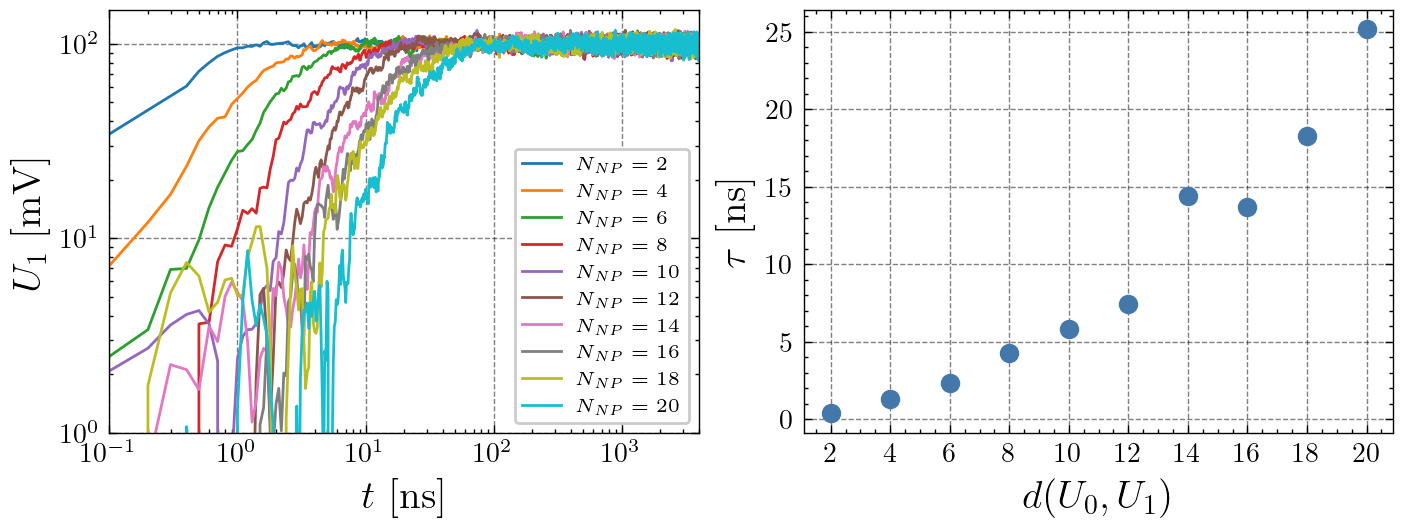

In [35]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ms  = ['o','s','^','v','<','>']
cm  = plt.get_cmap('tab20')

for i, N in enumerate(N_vals):

    y_val   = data_string[N]['Current'].values*1000
    y_val_e = data_string[N]['Error'].values*1000
    pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', c=cm((i)/len(N_vals)))
    # pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', marker=ms[i%len(ms)], markevery=(20,100), ls='')
    # ax.plot(t_vals, stretched_saturation_curve(t_vals,*params[i]), c=pp[0].get_color())
    # ax.plot(t_vals, saturation_cuve(t_vals,*params[i]), c=pp[0].get_color())
    # ax.fill_between(t_vals, y_val-y_val_e, y_val+y_val_e, color='black', alpha=0.2)

ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')
ax.set_xlabel("$t$ [ns]", fontsize='x-large')
ax.legend(frameon=True, loc='lower right', fontsize='x-small', ncol=1)
ax.set_ylim(1,150)
ax.set_xlim(0.1,4000)
ax.set_xscale('log')
ax.set_yscale('log')

ax  = fig.add_subplot(1,2,2)
ax.plot(np.array(N_vals), taus, 'o')
ax.set_ylabel("$\\tau$ [ns]", fontsize='x-large')
ax.set_xlabel("$d(U_0,U_1)$", fontsize='x-large')
ax.set_xticks(N_vals)

fig.savefig("../plots/string_time_scale_vs_system_size_room_temp.svg", transparent=True)
fig.savefig("../plots/string_time_scale_vs_system_size_room_temp.pdf", transparent=False)

In [1]:
path    = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/time_scale/"
N_vals  = [3,5,7,9,11,13]
data    = {N : pd.read_csv(f"{path}Nx={N}_Ny={N}_Nz=1_Ne=8.csv") for N in N_vals}
states  = pd.read_csv(f"{path}mean_state_Nx=11_Ny=11_Nz=1_Ne=8.csv")
x_val   = data[5]['E0'].values*1000
t_val   = np.arange(len(x_val))*1e-10*1e9

NameError: name 'pd' is not defined

In [195]:
taus    = []
params  = []
covs    = []
starts  = len(N_vals)*[0]
stops   = len(N_vals)*[5000]

for i, N in enumerate(N_vals):
    x_fit   = t_vals[starts[i]:stops[i]]
    y_fit   = data[N]['Current'].values[starts[i]:stops[i]]*1000
    p, cov  = curve_fit(stretched_saturation_curve, x_fit, y_fit, p0=[10,20,0], bounds=((0,0,0),(200,30,2)))
    taus.append(p[0])
    params.append(p)
    covs.append(np.sqrt(cov[0,0]))
    
params

[array([ 1.81094987, 10.22819503,  0.80748377]),
 array([3.63031915, 8.29002692, 1.15052751]),
 array([10.64988641,  9.33251991,  1.09799198]),
 array([29.63764537, 13.22357227,  1.17027035]),
 array([68.81264448, 25.9804675 ,  1.82999042]),
 array([128.50547546,  27.69472734,   1.53167537])]

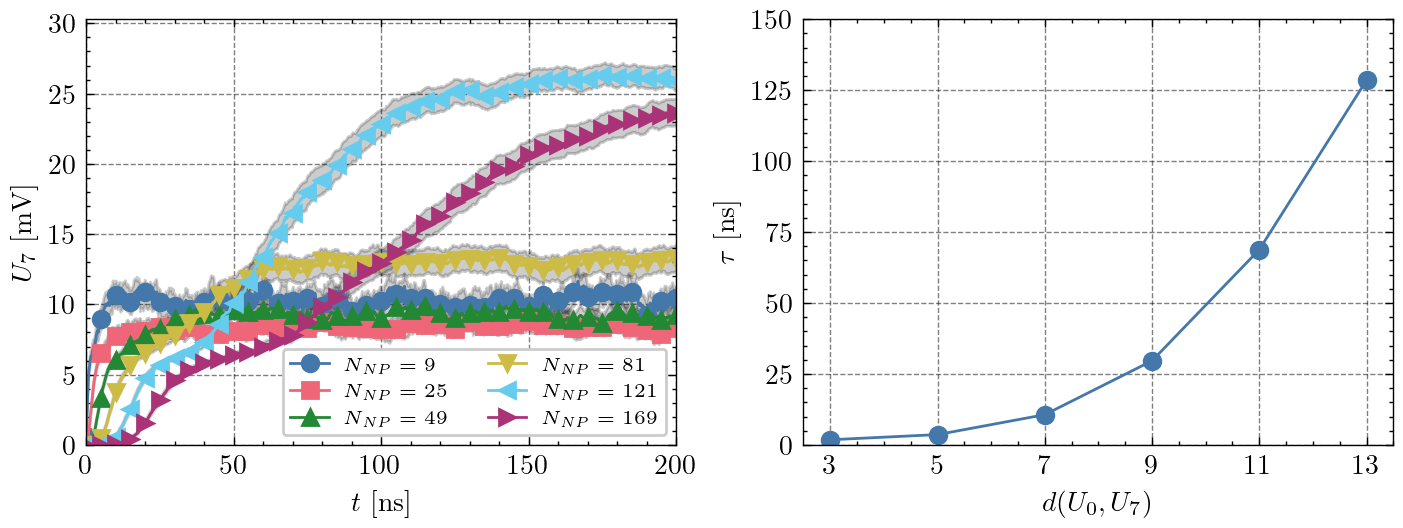

In [200]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ms  = ['o','s','^','v','<','>']

for i, N in enumerate(N_vals):

    y_val   = data[N]['Current'].values*1000
    y_val_e = data[N]['Error'].values*1000
    ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N**2}$', marker=ms[i%len(ms)], markevery=(50))
    ax.fill_between(t_vals, y_val-y_val_e, y_val+y_val_e, color='black', alpha=0.2)

ax.set_ylabel("$U_7$ [mV]")
ax.set_xlabel("$t$ [ns]")
ax.legend(frameon=True, loc='lower right', fontsize='x-small', ncol=2)
ax.set_xlim(0,200)
ax.set_ylim(0)

ax  = fig.add_subplot(1,2,2)
ax.plot(np.array(N_vals), taus, '-o')
ax.set_ylabel("$\\tau$ [ns]")
ax.set_xlabel("$d(U_0,U_7)$")
ax.set_xticks(N_vals)
ax.set_ylim(0,150)

fig.savefig("../plots/network_time_scale_vs_system_size.svg", transparent=True)
fig.savefig("../plots/network_time_scale_vs_system_size.pdf", transparent=False)

In [214]:
[i*11+11//2 for i in range(11)] + [121]

[5, 16, 27, 38, 49, 60, 71, 82, 93, 104, 115, 121]

In [213]:
11*11

121

In [218]:
states_string

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.045312,0.015904,0.004412,0.001203,0.000328,0.000089,0.000024,0.000007,0.000002,4.936670e-07,1.347624e-07,3.742445e-08,1.272531e-08
1,0.057602,0.026976,0.008983,0.002496,0.000680,0.000185,0.000051,0.000014,0.000004,1.024357e-06,2.796315e-07,7.765559e-08,2.640497e-08
2,0.065364,0.034964,0.014120,0.004286,0.001168,0.000318,0.000087,0.000024,0.000006,1.758922e-06,4.801547e-07,1.333423e-07,4.533993e-08
3,0.070252,0.040504,0.019233,0.006894,0.001949,0.000531,0.000145,0.000039,0.000011,2.934340e-06,8.010234e-07,2.224497e-07,7.563884e-08
4,0.072698,0.045456,0.023894,0.009730,0.002951,0.000805,0.000219,0.000060,0.000016,4.443235e-06,1.212925e-06,3.368377e-07,1.145338e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.102055,0.087345,0.098696,0.086763,0.097898,0.086491,0.093324,0.086367,0.083075,9.727145e-02,8.570426e-02,9.701321e-02,8.177111e-02
4995,0.102055,0.087345,0.098696,0.086763,0.097898,0.086491,0.093324,0.086367,0.083075,9.727145e-02,8.570426e-02,9.701321e-02,8.177111e-02
4996,0.102055,0.087343,0.098688,0.086732,0.097928,0.086499,0.093326,0.086367,0.083076,9.727150e-02,8.570427e-02,9.701322e-02,8.177111e-02
4997,0.102055,0.087343,0.098688,0.086732,0.097928,0.086499,0.093326,0.086367,0.083076,9.727150e-02,8.570427e-02,9.701322e-02,8.177111e-02


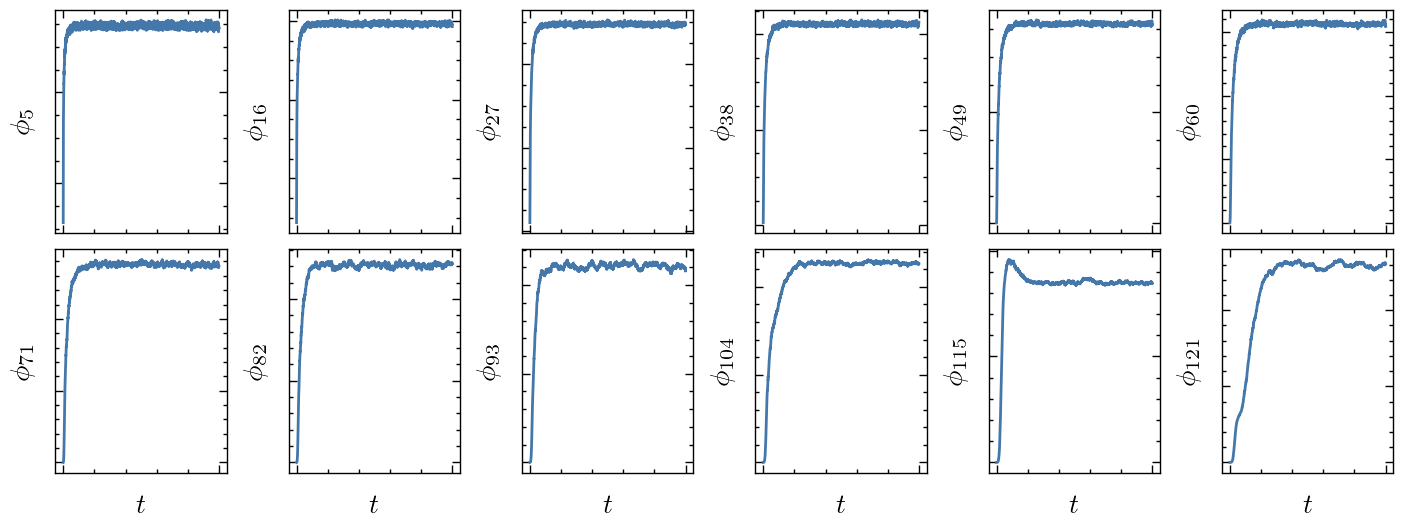

In [235]:
i_np    = [i*11+11//2 for i in range(11)] + [121]
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

for j, i in enumerate(i_np):

    ax  = fig.add_subplot(2,6,j+1)
    y   = states[f"{i}"].values*1000

    ax.plot(t_vals, y)
    ax.set_ylabel("$\phi_{"f'{i}'+"}$")
    ax.set_yticklabels("")
    ax.set_xticklabels("")
    ax.grid(False)

    if j > 5:
        ax.set_xlabel("$t$")
    
fig.savefig("../plots/network_states.svg", transparent=True)
fig.savefig("../plots/network_states.pdf", transparent=False)

---